# Super resolution

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [3]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [4]:
il = ImageItemList.from_folder(path_hr)

In [5]:
il

ImageItemList (7390 items)
[Image (3, 500, 388), Image (3, 379, 500), Image (3, 1600, 1725), Image (3, 354, 500), Image (3, 375, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images

In [6]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
# to create smaller images, uncomment the next line when you run this the first time
#parallel(resize_one, il.items)

In [8]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [10]:
data = get_data(bs,size)

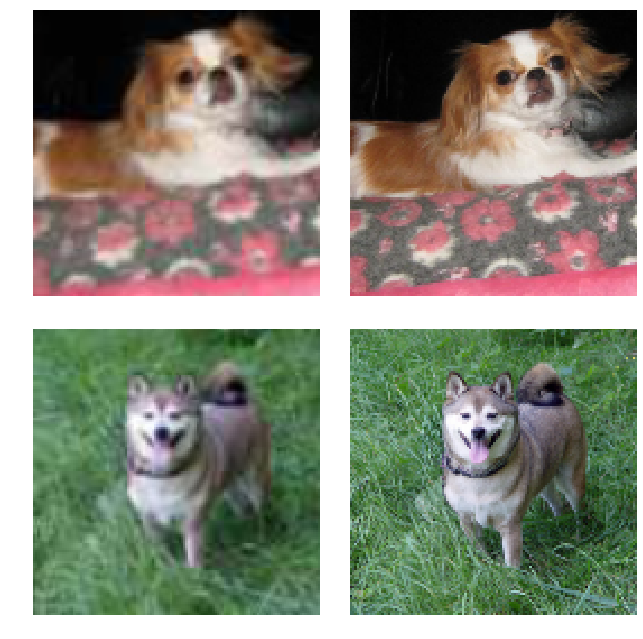

In [11]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

# Feature Loss

In [12]:
type(data)

fastai.vision.data.ImageDataBunch

In [13]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
gram_matrix(t)

tensor([[[0.1067, 0.0822, 0.0788],
         [0.0822, 0.0670, 0.0637],
         [0.0788, 0.0637, 0.0617]],

        [[0.1067, 0.0822, 0.0788],
         [0.0822, 0.0670, 0.0637],
         [0.0788, 0.0637, 0.0617]]])

In [16]:
base_loss = F.l1_loss

In [17]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [19]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [21]:
fastai.__version__

'1.0.37'

In [22]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
#gc.collect();
learn = learn.to_fp16()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


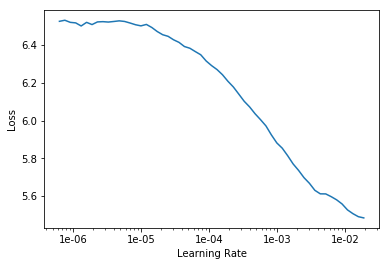

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-3

In [26]:
learn.data.valid_dl.add_tfm(to_half)

In [27]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    #learn.show_results(rows=1, imgsize=5)

In [28]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.863914,3.659209,0.141154,0.228111,0.313428,0.221198,0.546422,1.189121,1.019774
2,3.737235,3.534772,0.141941,0.224019,0.304782,0.212704,0.523689,1.149221,0.978415
3,3.688422,3.452353,0.143522,0.224052,0.301139,0.207175,0.502347,1.120051,0.954067
4,3.600593,3.380098,0.144197,0.221464,0.295891,0.201804,0.490973,1.095116,0.930653
5,3.566358,3.398578,0.147166,0.221364,0.294918,0.202431,0.494738,1.104177,0.933784
6,3.540614,3.324974,0.142428,0.220050,0.291613,0.199153,0.471456,1.080977,0.919296
7,3.482073,3.273161,0.143445,0.221607,0.289761,0.195348,0.458956,1.064773,0.899270
8,3.465348,3.221233,0.142326,0.218647,0.285159,0.192288,0.446964,1.046338,0.889511
9,3.409238,3.224303,0.136519,0.218485,0.284825,0.192054,0.460643,1.047429,0.884349
10,3.334802,3.105479,0.134400,0.214839,0.277884,0.184990,0.427472,1.013384,0.852509


In [31]:
learn.show_results(rows=1, imgsize=5)

AttributeError: 'DynamicUnet' object has no attribute 'to_fp16'

In [33]:
learn.unfreeze()

In [34]:
do_fit('1b', slice(1e-5,1e-3))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.339648,3.129377,0.134005,0.215633,0.279659,0.186426,0.433654,1.021466,0.858534
2,3.334224,3.123165,0.134462,0.215753,0.279494,0.186227,0.430333,1.019025,0.857872
3,3.329423,3.117404,0.134575,0.215763,0.279259,0.185703,0.428991,1.017465,0.855647
4,3.326091,3.113551,0.134389,0.215323,0.278598,0.185432,0.429651,1.015625,0.854533
5,3.319793,3.107970,0.134477,0.215149,0.278718,0.185099,0.426288,1.014849,0.853390
6,3.322589,3.096851,0.134408,0.214438,0.277723,0.184405,0.424524,1.010975,0.850378
7,3.324184,3.099923,0.133777,0.214072,0.277280,0.184523,0.427721,1.012383,0.850166
8,3.298079,3.093807,0.135023,0.214870,0.277486,0.184422,0.421962,1.009737,0.850308
9,3.283945,3.092615,0.134340,0.214497,0.276787,0.183993,0.426047,1.009223,0.847729
10,3.272832,3.069991,0.133982,0.213854,0.275691,0.182837,0.419206,1.002851,0.841569


In [35]:
learn = learn.to_fp16() # for 2080 to make it train faster and stop blowing ram

In [36]:
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

In [37]:
gc.collect()

49

In [38]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,nan,nan,nan,0.367705,0.383359,0.161459,1.747951,1.184294,0.432623
2,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
3,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
4,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
5,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
6,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
7,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
8,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
9,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623
10,nan,nan,nan,0.367705,0.383359,0.161459,1.747953,1.184294,0.432623


In [43]:
learn.unfreeze()

In [44]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2


RuntimeError: CUDA out of memory. Tried to allocate 193.62 MiB (GPU 0; 10.72 GiB total capacity; 6.89 GiB already allocated; 103.06 MiB free; 256.79 MiB cached)

# Test

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(819,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

In [ ]:
img = open_image(fn); img.shape

In [ ]:
_,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest')

In [ ]:
Image(img_hr).show(figsize=(18,15))